In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [3]:
inputfile = "/home/francisco/GitHub/DQN-Event-Summarization/data/cnn_tokenized/cnn_data_corpus.csv"
inputdict = "/home/francisco/GitHub/DQN-Event-Summarization/data/cnn_tokenized/cnn_total_corpus_smry.csv"

In [4]:
torch.manual_seed(1)

In [5]:
def rougueScores(genSummary, refSummary):
    genTotal, refTotal, intersection = 0, 0, 0
    for token in list(set(list(refSummary.keys()) + list(genSummary.keys()) )):
        intersection += min(refSummary[token], genSummary[token])
        refTotal += refSummary[token]
        genTotal += genSummary[token]

    recall = intersection / float(refTotal) if float(refTotal) > 0 else 0
    prec   = intersection / float(genTotal) if float(genTotal) > 0 else 0
    f1 = (2 * recall * prec) / (recall + prec) if (recall + prec) > 0 else 0
    
    return recall, prec, f1

def make_target(label, label_to_ix):
    return torch.LongTensor([label_to_ix[label]])

def make_bow_vector(sentence, word_to_ix):
    vec = torch.zeros(len(word_to_ix))
    for token in sentence:
        vec[token] += 1
    return vec.view(1, -1)

class BoWRegressor(nn.Module):  # inheriting from nn.Module!
    # calls the init function of nn.Module.  Dont get confused by syntax, always do it in an nn.Module
    def __init__(self, outputsize, vocab_size):        
        super(BoWRegressor, self).__init__()        
        self.linear = nn.Linear(vocab_size, outputsize)
        
    def forward(self, bow_vec):
        return F.relu(self.linear(bow_vec))

In [6]:
qdf = pd.read_csv(inputfile)
qdict = pd.read_csv(inputdict)

/home/francisco/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
queries = qdf['query_id']
sentences = qdf[[x for x in qdf.columns if 'stokens_' in x]]

true_summaries = {}
for queryid, true_summary in zip(queries, qdf['tstokens']):
    true_summaries[queryid] = Counter([int(x) for x in true_summary.split(" ")])

In [8]:
sentences['stokens_0'].head()

0                                      0 1 2 3 4 5 6 7
1    78 79 549 411 550 44 551 552 549 84 553 20001 ...
2                  37 549 788 41 20001 756 8 78 79 572
3    78 79 549 280 1168 105 1169 37 78 79 572 538 8...
4    78 79 549 139 1380 1381 318 9 1382 1383 8 1384...
Name: stokens_0, dtype: object

In [9]:
corpus_dict = dict(zip(qdict['id'].values, qdict['token'].values))

In [10]:
print([int(s) for s in sentences['stokens_0'][0].split(" ") ])
print([corpus_dict[int(w)] for w in sentences['stokens_0'][0].split(" ") if int(w) in corpus_dict])

[0, 1, 2, 3, 4, 5, 6, 7]
['i', 'm', '45', 'and', 'my', 'son', 'is']


In [11]:
trueSummary = Counter([1, 1, 1, 2, 2, 2, 2, 3, 3])

predSummary0 = Counter([1, 1, 1, 2, 2, 2, 2, 3, 3])

predSummary1 = Counter([1, 1, 1, 2, 2, 2, 2, 3, 3, 4])

predSummary2 = Counter([1, 1, 1, 2, 2, 2, 2, 3])

predSummary3 = Counter([4])

In [12]:
print(rougueScores(predSummary0, trueSummary))
print(rougueScores(predSummary1, trueSummary))
print(rougueScores(predSummary2, trueSummary))
print(rougueScores(predSummary3, trueSummary))

(1.0, 1.0, 1.0)
(1.0, 0.9, 0.9473684210526316)
(0.8888888888888888, 1.0, 0.9411764705882353)
(0.0, 0.0, 0)


In [13]:
n = 10

train_xs = torch.zeros(n, len(corpus_dict))
train_ys = torch.from_numpy(np.random.random((n, 2))).float()  # Simulating the output

for i, row in enumerate(sentences['stokens_0']):
    tokens = row.split(" ")
    if len(tokens) > 0 and i < n:
        train_xs[i, :] = make_bow_vector([int(s) for s in tokens], corpus_dict)

In [14]:
outputsize = 2 
vocab_size = len(corpus_dict)
model = BoWRegressor(outputsize, vocab_size)

In [15]:
model.zero_grad()

loss_function = nn.MSELoss()

rougue_preds = model(autograd.Variable(train_xs))
loss = loss_function(rougue_preds, autograd.Variable(train_ys))

print(
    (( (rougue_preds.data).cpu().numpy() - (autograd.Variable(train_ys).data).cpu().numpy() ) **2 ).mean()
     )
print(loss)

0.341431
Variable containing:
 0.3414
[torch.FloatTensor of size 1]



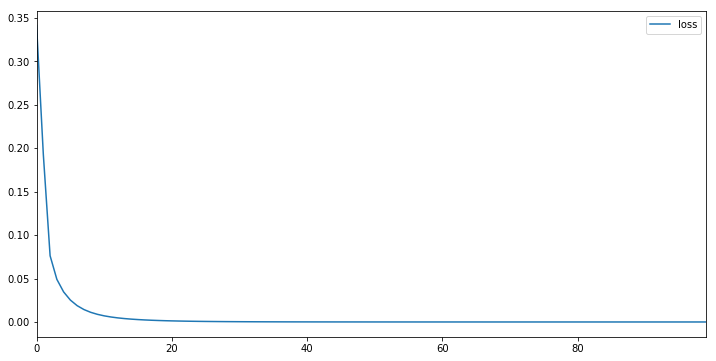

In [16]:
optimizer = optim.SGD(model.parameters(), lr=0.1)

lossf = {'loss': [], 'epoch': []}
for epoch in range(100):
    model.zero_grad()
    
    rougue_preds = model(autograd.Variable(train_xs))
    loss = loss_function(rougue_preds, autograd.Variable(train_ys))
    loss.backward()
    optimizer.step()
    lossf['loss'].append(loss.data[0])
    lossf['epoch'].append(epoch)
    
perf = pd.DataFrame(lossf)

perf.plot(y='loss', figsize=(12, 6))
plt.show()